# Figure 4

1. Image statistics (FFT, low level stats, symmetry, segments)
2. Wdf validation

In [1]:
from utils import *
from plot_params import *
from scipy.stats import kruskal, wilcoxon
from matplotlib.ticker import FormatStrFormatter
from scikit_posthocs import posthoc_dunn

In [2]:
save = True
savepath = r'D:\Data\DeepMouse\Figures\Figure5'

## 1. Image statistics

In [3]:
# Plotting functions
def plot_single_stat(stat, regions, name='', figsize=(6,5), yrange=None):
    '''Plot a single image statistic as boxplot'''
    # Remove possible nans
    stat = [d[~np.isnan(d)] for d in stat]
    fig, ax = pl.subplots(figsize=figsize)
    bp1 = ax.boxplot(stat, showfliers=False, positions=np.arange(1, len(regions)+1), widths=0.5, 
                     patch_artist=True, medianprops=dict(color='k'))

    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel(name)
    ax.set_xticklabels(regions)
    if yrange is not None:
        ax.set_ylim(yrange)

    print(kruskal(*stat))

    return fig

def plot_double_stat(stat1, stat2, regions, name='', figsize=(6,5), yrange=None):
    '''Plot a single image statistic as boxplot'''
    # Remove possible nans
    stat1 = [d[~np.isnan(d)] for d in stat1]
    stat2 = [d[~np.isnan(d)] for d in stat2]
    fig, ax = pl.subplots(figsize=figsize)
    positions = np.arange(1, len(regions)+1)

    bp1 = ax.boxplot(stat1, showfliers=False, positions=positions-0.2, widths=0.3, 
                     patch_artist=True, medianprops=dict(color='k'))

    for patch, color in zip(bp1['boxes'], colors):
        patch.set(color=color)
        patch.set_facecolor(color)

    for patch, color in zip(bp1['medians'], colors):
        patch.set(color='k')

    for i, patch in enumerate(bp1['whiskers']):
        patch.set(color=colors[i//2])

    for i, patch in enumerate(bp1['caps']):
        patch.set(color=colors[i//2])
        

    bp2 = ax.boxplot(stat2, showfliers=False, positions=positions+0.2, widths=0.3, 
                     patch_artist=True, medianprops=dict(color='k'))

    for patch, color in zip(bp2['boxes'], colors):
        patch.set(color=color)
        patch.set_facecolor('w')

    for patch, color in zip(bp2['medians'], colors):
        patch.set(color='k')

    for i, patch in enumerate(bp2['whiskers']):
        patch.set(color=colors[i//2])

    for i, patch in enumerate(bp2['caps']):
        patch.set(color=colors[i//2])
        

    ax.set_ylabel(name)
    ax.set_xticks(positions)
    ax.set_xticklabels(regions)
    if yrange is not None:
        ax.set_ylim(yrange)

    return fig

def plot_SF(SF, regions, sf_axis, cutoff=10, figsize=(6,5)):
    '''Plot the average SF distribution for each region'''
    SF_m = np.array([d.mean(axis=0) for d in SF])
    SF_s = np.array([d.std(axis=0)/np.sqrt(d.shape[0]) for d in SF])
    fig, ax = pl.subplots(figsize=figsize)
    for i, region in enumerate(regions):
        ax.plot(sf_axis[:cutoff], SF_m[i][:cutoff], color=colors[i], lw=.5)
        ax.fill_between(sf_axis[:cutoff], (SF_m[i]-SF_s[i])[:cutoff], (SF_m[i]+SF_s[i])[:cutoff], color=colors[i], alpha=.5, lw=0)
    
    ax.axhline(0, ls='--', color=[.5]*3)
    ax.set_xscale('log', base=2)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(0, sf_axis[cutoff-1])
    # ax.set_xlabel('Spatial frequency (cyc/deg)')
    # ax.set_ylabel('Average power (norm.)')
    return fig

def unpack_stats(particle_stats, area_thresh=2):
    '''Given a list of dictionaries containing particle stats, unpack them into a 
       summary statistic for each image.
    '''
    # Create a mask for each image to remove small particles
    masks = [d['area'] > area_thresh for d in particle_stats]

    # Count the number of particles
    nparticles = np.array([d.sum() for d in masks])

    # Average area
    area = np.array([np.nanmean(d['area'][masks[i]]) for i, d in enumerate(particle_stats)])

    # Average eccentricity
    eccentricity = np.array([np.nanmean(d['eccentricity'][masks[i]]) for i, d in enumerate(particle_stats)])

    summary = {'nparticles': nparticles,
               'area': area,
               'eccentricity': eccentricity}

    return summary

def get_OSI(vec, n=2):
    '''Calculate the orientation selectivity index'''
    angle = np.linspace(0, 2*np.pi-2*np.pi/vec.shape[0], vec.shape[0])
    vec = (vec-vec.min())/(vec.max()-vec.min())
    vec = vec/vec.sum()
    v = vec * np.exp(1j*n*angle)
    osi = np.abs(v.sum())
    return osi


In [4]:
fp_stats = r'D:\Data\DeepMouse\Results\image_analysis'
FFT =  [np.load(os.path.join(fp_stats, f"FFT_statistics_{region}_rep.npy"), allow_pickle=True) for region in regions]
FFT_raw =  [np.load(os.path.join(fp_stats, f"FFT_statistics_raw_{region}_rep.npy"), allow_pickle=True) for region in regions]

luminance = np.load(os.path.join(fp_stats, 'luminance_rep.npy'), allow_pickle=True).item()
contrast = np.load(os.path.join(fp_stats, 'contrast_rep.npy'), allow_pickle=True).item()
particles_white = np.load(os.path.join(fp_stats, 'particle_white_rep.npy'), allow_pickle=True).item()
particles_black = np.load(os.path.join(fp_stats, 'particle_black_rep.npy'), allow_pickle=True).item()

# Unpack everything
luminance = [luminance[region] for region in regions]
contrast = [contrast[region] for region in regions]
SF = [(np.vstack(d[:,0])) for d in FFT]
sf_axis =np.fft.fftfreq(64)[:32]
sf_axis = sf_axis[:-1] + np.diff(sf_axis)/2
sf_axis = 1/px2deg(1/sf_axis * 1080*1.6/135)

OS = [np.vstack(d[:,1]) for d in FFT_raw]
osi2 = [np.array([get_OSI(vec, n=2) for vec in d]) for d in OS]
osi4 = [np.array([get_OSI(vec, n=4) for vec in d]) for d in OS]
osi6 = [np.array([get_OSI(vec, n=6) for vec in d]) for d in OS]
osi10 = [np.array([get_OSI(vec, n=10) for vec in d]) for d in OS]

area_thresh = 4

summary_white = [unpack_stats(particles_white[region], area_thresh=area_thresh) for region in regions]
summary_black = [unpack_stats(particles_black[region], area_thresh=area_thresh) for region in regions]

c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: Mean of empty slice


KruskalResult(statistic=591.8446107803935, pvalue=1.1692451529399971e-125)


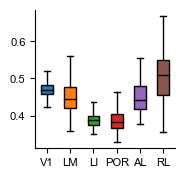

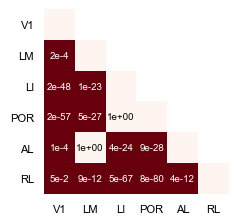

In [5]:
# Luminance
fig1 = plot_single_stat(luminance, regions, name='', figsize=(1.8,1.8))
if save: fig1.savefig(os.path.join(savepath, 'luminance.eps'),bbox_inches='tight')
stats1 = posthoc_dunn([d[~np.isnan(d)] for d in luminance], p_adjust='Bonferroni')

fig1_stats = plot_stats(np.array(stats1), regions, figsize=(2.4,2.4))
if save: fig1_stats.savefig(os.path.join(savepath, 'luminance_stats.pdf'),bbox_inches='tight')

KruskalResult(statistic=320.9147032075789, pvalue=3.182104144316707e-67)


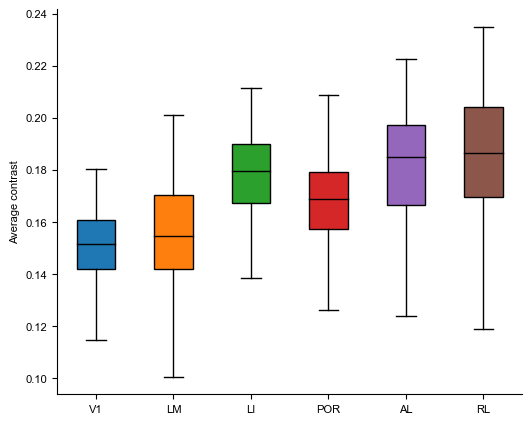

In [6]:
# Contrast
fig2 = plot_single_stat(contrast, regions, name='Average contrast')
if save: fig2.savefig(os.path.join(savepath, 'contrast.pdf'),bbox_inches='tight')

[0.00865836 0.03919597 0.14884872 0.33597802]


c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:84: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


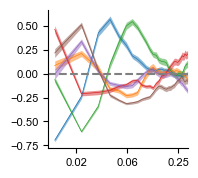

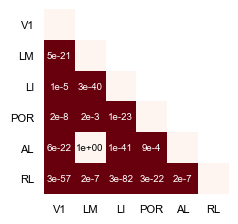

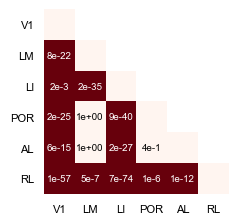

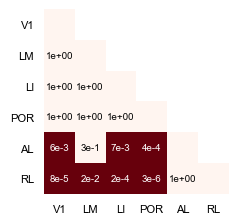

In [7]:
fig3 = plot_SF(SF, regions, sf_axis, cutoff=30, figsize=(1.8,1.8))
if save: fig3.savefig(os.path.join(savepath, 'sf.pdf'),bbox_inches='tight')

bins = (((np.arange(0,3+1)/3)**2 )*30).astype(int)
print(sf_axis[bins])
SF_bins = [[sf[:,bins[i]:bins[i+1]].mean(axis=-1) for sf in SF] for i in range(3)]

for i in range(3):
    stati = posthoc_dunn(SF_bins[i], p_adjust='bonferroni')
    fig3_statsi = plot_stats(np.array(stati), regions, figsize=(2.4,2.4))
    if save: fig3_statsi.savefig(os.path.join(savepath, f'sf_stats{i}.pdf'),bbox_inches='tight')


V1 MannwhitneyuResult(statistic=31717.5, pvalue=1.7693936628708485e-24)
LM MannwhitneyuResult(statistic=21051.0, pvalue=6.670228917392481e-17)
LI MannwhitneyuResult(statistic=17956.0, pvalue=1.7349573405429063e-47)
POR MannwhitneyuResult(statistic=36692.5, pvalue=4.666162884945341e-59)
AL MannwhitneyuResult(statistic=14595.0, pvalue=0.34835379555523005)
RL MannwhitneyuResult(statistic=26493.0, pvalue=1.583258520969434e-08)


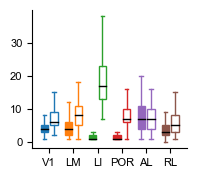

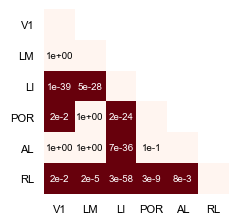

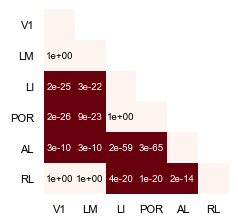

In [8]:
# nparticles
# fig4 = plot_single_stat([d['nparticles'] for d in summary_white], regions, name='#Particles (white)')
# fig5 = plot_single_stat([d['nparticles'] for d in summary_black], regions, name='#Particles (black)')

fig45 = plot_double_stat([d['nparticles'] for d in summary_black], [d['nparticles'] for d in summary_white], regions, name='', figsize=(2,1.8))

if save: fig45.savefig(os.path.join(savepath, 'particles_N.eps'),bbox_inches='tight')

stats41 = posthoc_dunn([d['nparticles'] for d in summary_white], p_adjust='Bonferroni')
fig41_stats = plot_stats(np.array(stats41), regions, figsize=(2.4,2.4))
if save: fig41_stats.savefig(os.path.join(savepath, 'particles_N_stats_white.pdf'),bbox_inches='tight')

stats42 = posthoc_dunn([d['nparticles'] for d in summary_black], p_adjust='Bonferroni')
fig42_stats = plot_stats(np.array(stats42), regions, figsize=(2.4,2.4))
if save: fig42_stats.savefig(os.path.join(savepath, 'particles_N_stats_black.pdf'),bbox_inches='tight')

for i, region in enumerate(regions):
    print(region, mannwhitneyu(summary_white[i]['nparticles'], summary_black[i]['nparticles']))

V1 MannwhitneyuResult(statistic=3073.5, pvalue=1.5591464320945437e-48)
LM MannwhitneyuResult(statistic=3145.0, pvalue=5.141552655961834e-34)
LI MannwhitneyuResult(statistic=0.0, pvalue=1.859454147695551e-45)
POR MannwhitneyuResult(statistic=129.0, pvalue=1.5059175820613235e-64)
AL MannwhitneyuResult(statistic=8561.5, pvalue=3.998883275233068e-13)
RL MannwhitneyuResult(statistic=15284.0, pvalue=6.144965548146288e-05)


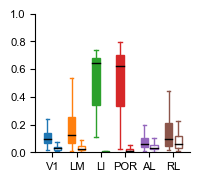

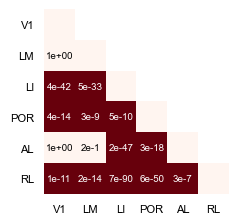

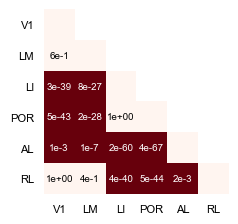

In [9]:
# Area
# fig6 = plot_single_stat([d['area'] for d in summary_white], regions, name='Area (white)')
# fig7 = plot_single_stat([d['area'] for d in summary_black], regions, name='Area (black)')

fig67 = plot_double_stat([d['area']/(64*64) for d in summary_black], [d['area']/(64*64) for d in summary_white], regions, name='', figsize=(2,1.8), yrange=(0,1))

if save: fig67.savefig(os.path.join(savepath, 'particles_area.eps'),bbox_inches='tight')

stats61 = posthoc_dunn([d['area'] for d in summary_white], p_adjust='Bonferroni')
fig61_stats = plot_stats(np.array(stats61), regions, figsize=(2.4,2.4))
if save: fig61_stats.savefig(os.path.join(savepath, 'particles_area_stats_white.pdf'),bbox_inches='tight')

stats62 = posthoc_dunn([d['area'] for d in summary_black], p_adjust='Bonferroni')
fig62_stats = plot_stats(np.array(stats62), regions, figsize=(2.4,2.4))
if save: fig62_stats.savefig(os.path.join(savepath, 'particles_area_stats_black.pdf'),bbox_inches='tight')

for i, region in enumerate(regions):
    print(region, mannwhitneyu(summary_white[i]['area'][~np.isnan(summary_white[i]['area'])], summary_black[i]['area'][~np.isnan(summary_black[i]['area'])]))

KruskalResult(statistic=78.26976847569995, pvalue=1.930557915120649e-15)
KruskalResult(statistic=489.78599070718474, pvalue=1.2788193157134675e-103)


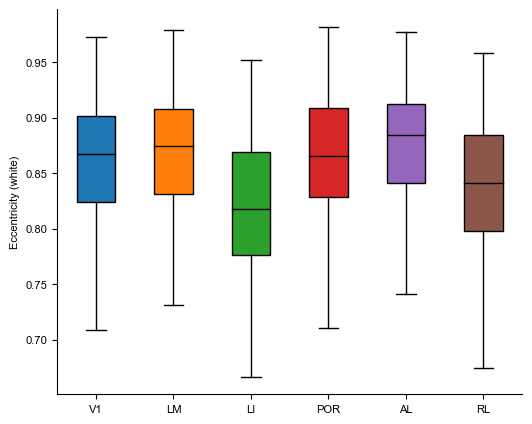

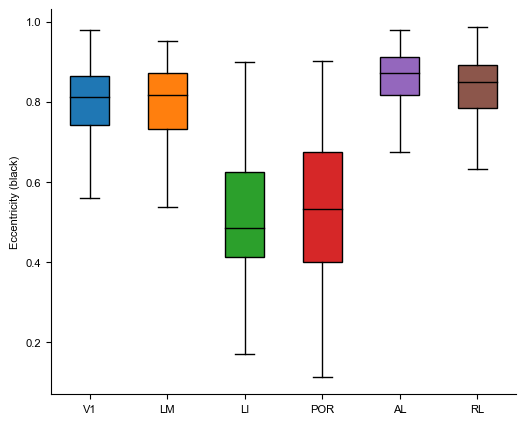

In [10]:
# Eccentricity
fig8 = plot_single_stat([d['eccentricity'] for d in summary_white], regions, name='Eccentricity (white)')
fig9 = plot_single_stat([d['eccentricity'] for d in summary_black], regions, name='Eccentricity (black)')

if save: fig8.savefig(os.path.join(savepath, 'white_eccentricity.pdf'),bbox_inches='tight')
if save: fig9.savefig(os.path.join(savepath, 'black_eccentricity.pdf'),bbox_inches='tight')

KruskalResult(statistic=144.337524335112, pvalue=2.1398703971820138e-29)


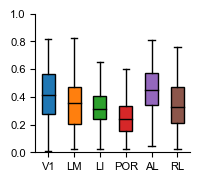

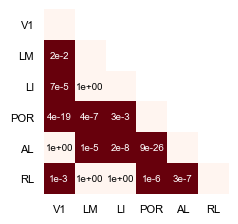

In [11]:
# OSI 2
fig10 = plot_single_stat(osi2, regions, name='', figsize=(2,1.8), yrange=(0,1))
if save: fig10.savefig(os.path.join(savepath, 'osi2.eps'),bbox_inches='tight')

stats10 = posthoc_dunn([d[~np.isnan(d)] for d in osi2], p_adjust='Bonferroni')
fig10_stats = plot_stats(np.array(stats10), regions, figsize=(2.4,2.4))
if save: fig10_stats.savefig(os.path.join(savepath, 'osi2_stats.pdf'),bbox_inches='tight')


KruskalResult(statistic=206.34709400319662, pvalue=1.2454112840702535e-42)


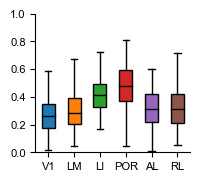

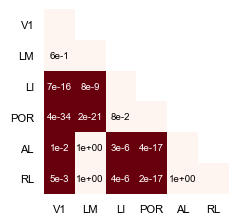

In [12]:
# OSI 4
fig11 = plot_single_stat(osi4, regions, name='', figsize=(2,1.8), yrange=(0,1))
if save: fig11.savefig(os.path.join(savepath, 'osi4.eps'),bbox_inches='tight')

stats11 = posthoc_dunn([d[~np.isnan(d)] for d in osi4], p_adjust='Bonferroni')
fig11_stats = plot_stats(np.array(stats11), regions, figsize=(2.4,2.4))
if save: fig11_stats.savefig(os.path.join(savepath, 'osi4_stats.pdf'),bbox_inches='tight')

KruskalResult(statistic=73.68095134863051, pvalue=1.7530574449567743e-14)


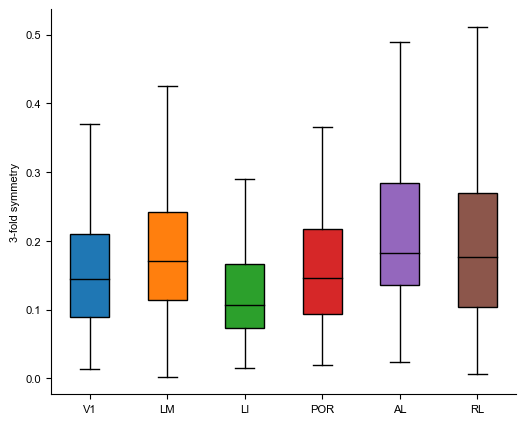

In [13]:
# OSI 6
fig12 = plot_single_stat(osi6, regions, name='3-fold symmetry')
if save: fig12.savefig(os.path.join(savepath, 'osi6.pdf'),bbox_inches='tight')

KruskalResult(statistic=114.14422348565859, pvalue=5.448287902718107e-23)


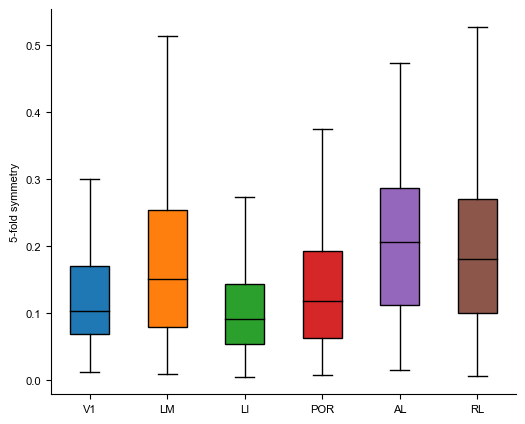

In [14]:
# OSI 10
fig13 = plot_single_stat(osi10, regions, name='5-fold symmetry')
if save: fig13.savefig(os.path.join(savepath, 'osi10.pdf'),bbox_inches='tight')

## Widefield validation

In [3]:
# Plotting functions
def get_population_mean(data, window=(5,11)):
    '''Given widefield data, extract the mean activity formatted as [region][stimulus]'''
    activity = data['segmented_norm']
    labels = data['labels']

    activity_m = []
    # Calculate the mean activity 
    for i in range(6):
        U, S, Vt = np.linalg.svd(activity[:,i])
        #act = U[:,:5] @ np.diag(S[:5]) @ Vt[:5]
        #Y1 = act[:,window[0]:window[1]].mean(axis=-1)-act[:,:window[0]].mean(axis=-1)
        Y1 = activity[:,i] @ Vt.T[:,0] * np.sign(Vt.T[:,0].sum())
        activity_m.append(Y1)
    #activity_m = activity[:,:,window[0]:window[1]].mean(axis=-1)-activity[:,:,:window[0]].mean(axis=-1)

    activity_m = np.array(activity_m).T
    results = [[activity_m[labels==i,i], activity_m[labels!=i,i]] for i in range(6)]

    activity_m = StandardScaler().fit_transform(activity_m)
    results2 = []
    for i in range(6):
        mask = np.ones(6)
        mask[i] = 0
        mask = mask.astype(bool)
        results2.append([activity_m[labels==i,i], activity_m[labels==i][:,mask].mean(axis=1)])
    return results, results2

def combine_wdf(data):
    '''Combine the data of multiple recordings'''
    combined = []
    for i in range(6):
        within = np.concatenate([d[i][0] for d in data])
        across = np.concatenate([d[i][1] for d in data])
        all_data = np.concatenate([within, across])
        mu, s = all_data.mean(), all_data.std()
        within = (within-mu)/s  
        across = (across-mu)/s
        combined.append([within, across])

    return combined

def plot_wdf(data, figsize=(6,5), ylabel=''):
    '''Plot wdf data as boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i, region in enumerate(regions):
        # x = np.arange(1,3)+i*2+i
        # for j in range(data[i][0].shape[0]):
        #     ax.plot(x, [data[i][0][j], data[i][1][j]], 'k-', lw=.1, alpha=.2)
        # ax.plot(x, [np.median(data[i][0]), np.median(data[i][1])], ls='-', marker='s', color=colors[i], lw=1, ms=2)
        bp1 = ax.boxplot(data[i], showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)
    return fig
    

In [4]:
fp_base = r'D:\Data\DeepMouse\Results\tuning_dynamics'
fps = ['results_RT114.npy', 'results_RT117.npy']

wdf = [np.load(os.path.join(fp_base, name), allow_pickle=True).item() for name in fps]
# activity_m = [get_population_mean(data)[0] for data in wdf]
activity_m2 = [get_population_mean(data)[1] for data in wdf]
# activity_combined = combine_wdf(activity_m)
activity_combined2 = combine_wdf(activity_m2)

In [98]:
activity_combined2[1][0].shape

(500,)

V1 WilcoxonResult(statistic=43519.0, pvalue=3.4021885722563968e-09)
LM WilcoxonResult(statistic=57319.0, pvalue=0.10068498455157134)
LI WilcoxonResult(statistic=44975.0, pvalue=4.74895868732914e-08)
POR WilcoxonResult(statistic=53843.0, pvalue=0.0065890914750506005)
AL WilcoxonResult(statistic=40275.0, pvalue=4.69439248030959e-12)
RL WilcoxonResult(statistic=54488.0, pvalue=0.0118230739539401)


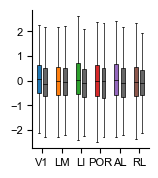

In [6]:
fig14 = plot_wdf(activity_combined2, figsize=(1.5,1.8))

if save:
    fig14.savefig(os.path.join(savepath, 'neuron_mean_invivo2.eps'), bbox_inches='tight')

for i, a in enumerate(activity_combined2): print(regions[i], wilcoxon(a[0], a[1]))